In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset, get_labelencoder_mapping
from insectrec.utils import to_weeknr
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats

seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

nb_classes = 9

if nb_classes == 3:
    target_classes = ['v','wmv','v(cy)','other']
elif nb_classes == 9:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','sw','t','other']
elif nb_classes == 6:
    target_classes = ['m','v','bl','c','wmv','v(cy)','other']
elif nb_classes == 21:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','gaasvlieg','grv','k','kever','nl','psylloidea','sp','sst','sw','t','vlieg','weg','wnv','wswl','other']
elif nb_classes == 1:
    target_classes = ['wmv', 'other']

epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

# Dataframe for 2019 data (all plates)

In [2]:
date_mapping = {
    "1926719": "w30",
    "1219719": "w29",
    "02090819": "w32",
    "262719" : "w31",
    "512719": "w28",
    "09160819": "w33",
    "2128619": "w26",
    "2856719": "w27",
    "30719": "w30",
    "8719": "w27",
    "15": "w28"
}

# Creating the location mapping to fix location names from plates
location_mapping = {
    "herent": "herent",
    "her": "herent",
    "kampen": "kampenhout",
    "brainelal": "brainelalleud",
    "brainlal": "brainelalleud",
    "beauvech": "beauvechain",
    "beauv": "beauvechain",
    "beavech" : "beauvechain",
    "Racour" : "racour",
    "racour": "racour",
    "Merchtem": "merchtem"
}

# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_2019 = pd.DataFrame()
df_2019['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/2019*.jpg"))
df_2019['pname'] = df_2019['x'].apply(lambda p: p.split('/')[-1][:-4])
df_2019['pname'] = df_2019['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_2019['y_text'] = df_2019['x'].apply(lambda x: x.split('/')[-2])
df_2019['y_text'] = df_2019['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

if nb_classes == 3:
    df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(10000, random_state=42).index, axis='index', inplace=True)
elif nb_classes == 1:
    df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(14000, random_state=42).index, axis='index', inplace=True)
else:
    df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)
# df_2019.drop(df_2019[df_2019.y_text == 'other'].index, axis='index', inplace=True)

df_2019['y'] = le.fit_transform(df_2019.y_text)
df_2019['location'] = df_2019.pname.apply(lambda x: x.split('_')[1])
df_2019.location = df_2019.location.str.lower()
df_2019.location = df_2019['location'].map(location_mapping)
df_2019['date'] = df_2019.pname.apply(lambda x: x.split('_')[2]).str.lower()
df_2019['date'] = df_2019.date.apply(lambda x: date_mapping[x] if x in list(date_mapping.keys()) else x)

assert df_2019.pname.apply(lambda x: x.startswith('2019')).all()

# 2019 Test plates

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Test set class balance
wmv      622
c        300
v        285
other    233
m        230
t        226
v(cy)    158
sw       135
bv       129
bl       113
Name: y_text, dtype: int64


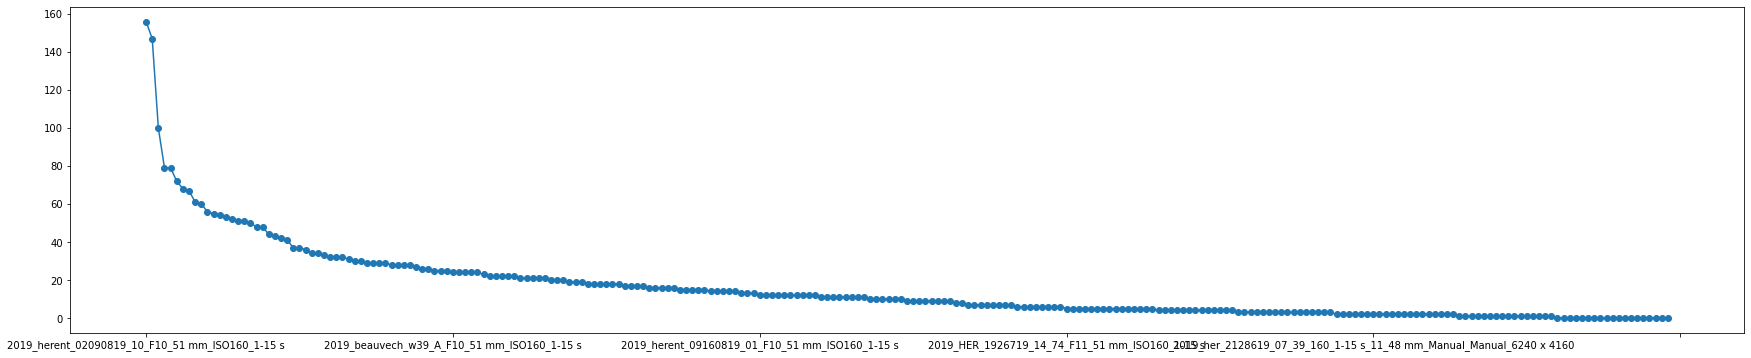

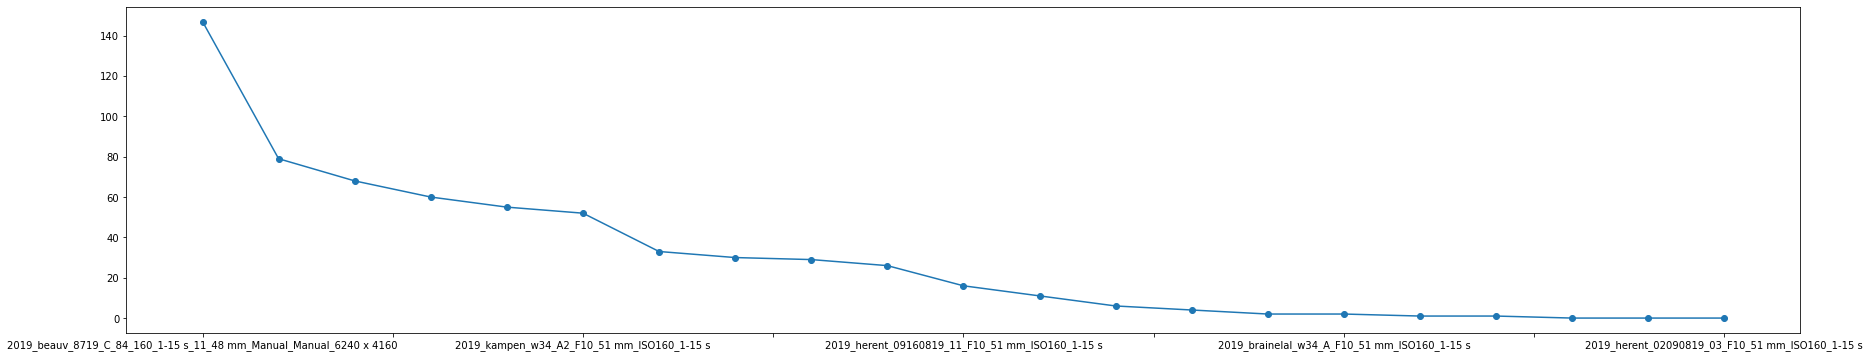

In [3]:
# Sampling some test plates. 2 from first 5, 2 from next five....
target_insect_dict = {}
for i, sub in df_2019.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)
test_plates = []
test_plates.extend(ser.iloc[:5].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[5:10].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[10:15].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[20:].sample(15, random_state=42).index.values.tolist())
test_plates = ser.loc[test_plates].sort_values(ascending=False).index.tolist()
# Plotting
ser.plot(marker='o', figsize=(30,6))
plt.figure()
ser.loc[test_plates].sort_values(ascending=False).plot(marker='o', figsize=(30,6))

X_test = df_2019.x[df_2019.pname.isin(test_plates)]
y_test = df_2019.y[df_2019.pname.isin(test_plates)]
print("Test set class balance")
print(df_2019[df_2019.pname.isin(test_plates) ].y_text.value_counts())

## Loading the Model (trained with 2019 data)

In [4]:
base_model = DenseNet121(include_top=False, weights=None, 
                        input_shape=(img_dim,img_dim,3))
# EfficientNetB2
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(nb_classes+1, activation=None)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

top_weights_path = f"{created_data_path}/weights/{modelname}.h5"
model.load_weights(top_weights_path)

# Model predictions 2019 data (test plates)

In [5]:
pred = model.predict(valid_generator(X_test.tolist(), y_test.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)
y_pred = np.argmax(pred, axis=1)
df_2019test = df_2019[df_2019.x.isin(X_test)]
df_2019test['pred'] = y_pred

get_labelencoder_mapping(le)
name_map = dict(zip(le.transform(le.classes_), le.classes_))
inv_name_map = {v: k for k, v in name_map.items()}

print(name_map)

76/75 [==============================] - 15s 192ms/step
{0: 'bl', 1: 'bv', 2: 'c', 3: 'm', 4: 'other', 5: 'sw', 6: 't', 7: 'v', 8: 'v(cy)', 9: 'wmv'}


/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
# INCLUDE WEEK NUMBERS IN 2019 Data
# from insectrec.utils import to_weeknr
# df_2019['date'] = df_2019.pname.apply(lambda x: x.split('_')[2])
# df_2019['weeknr'] = df_2019['date'].apply(lambda x: x if x.startswith('w') else to_weeknr(date=x))
# df_2019.weeknr

In [7]:
df_2019test.sample(5)

,x,pname,y_text,y,location,date,pred
5381,/home/kalfasyan/data/images/sticky_plates/crea...,2019_BRAINELAL_W29_A_40_F11_51 mm_ISO160_1-15 s,c,2,brainelalleud,w29,2
20332,/home/kalfasyan/data/images/sticky_plates/crea...,2019_her_2856719_08_08_160_1-15 s_11_48 mm_Man...,other,4,herent,w27,4
7133,/home/kalfasyan/data/images/sticky_plates/crea...,2019_brainelal_w34_A_F10_51 mm_ISO160_1-15 s,c,2,brainelalleud,w34,2
12003,/home/kalfasyan/data/images/sticky_plates/crea...,2019_kampen_w32_AAA_16_F10_51 mm_ISO160_1-15 s...,wmv,9,kampenhout,w32,9
17380,/home/kalfasyan/data/images/sticky_plates/crea...,2019_her_2856719_08_08_160_1-15 s_11_48 mm_Man...,v,7,herent,w27,7


## Confusion matrix (model trained with 2019 data)

0.69


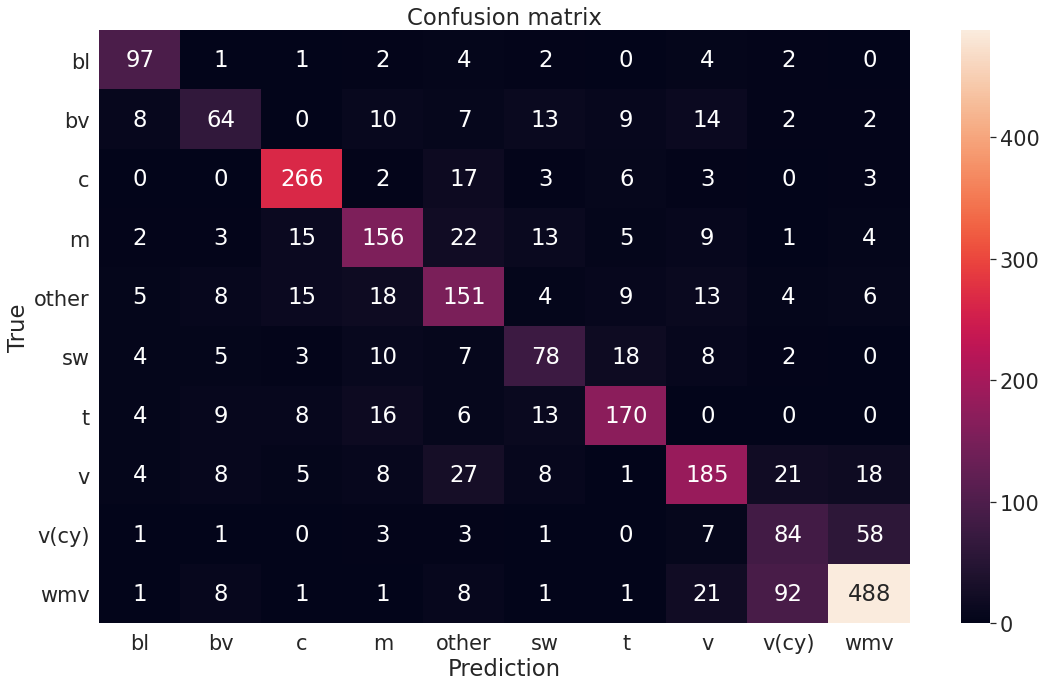

In [57]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(f"{balanced_accuracy_score(y_test, y_pred):.2}")

sns.set(font_scale=1.9)
plt.figure(figsize=(16,10))
cm = confusion_matrix(le.fit_transform(y_test), y_pred, normalize=None)

sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()), fmt='g',
           vmin=0, vmax=np.max(cm))
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title(f"Confusion matrix")
sns.set(font_scale=1.8)
plt.tight_layout()
plt.savefig(f"{created_data_path}/results/confusionmatrix_2019data_{nb_classes}classes_nonormalization.png")

In [111]:
pd.DataFrame({"pred": pd.Series(y_pred).value_counts().values, "species": pd.Series(y_pred).value_counts().index.map(name_map)})

,pred,species
0,579,wmv
1,314,c
2,264,v
3,252,other
4,226,m
5,219,t
6,208,v(cy)
7,136,sw
8,126,bl
9,107,bv


0.69


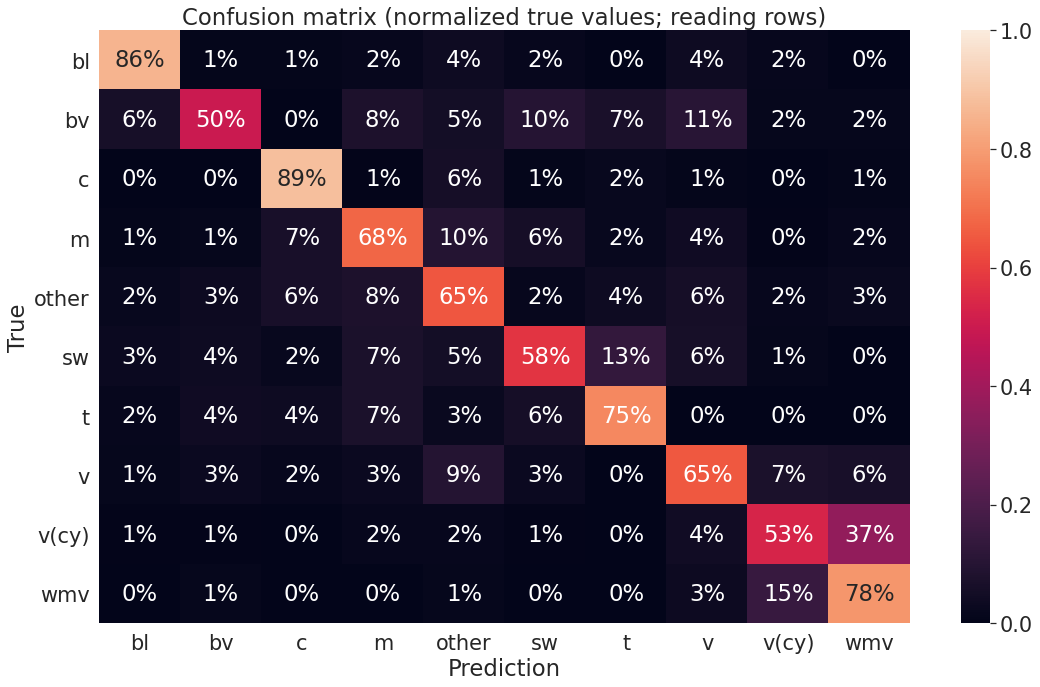

In [61]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(f"{balanced_accuracy_score(y_test, y_pred):.2}")

sns.set(font_scale=1.9)
plt.figure(figsize=(16,10))
cm = confusion_matrix(le.fit_transform(y_test), y_pred, normalize='true')

sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()), fmt='.0%',
           vmin=0, vmax=1)
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title(f"Confusion matrix (normalized true values; reading rows)")
sns.set(font_scale=1.8)
plt.tight_layout()
plt.savefig(f"{created_data_path}/results/confusionmatrix_2019data_{nb_classes}classes_normalizeTrue.png")

0.69


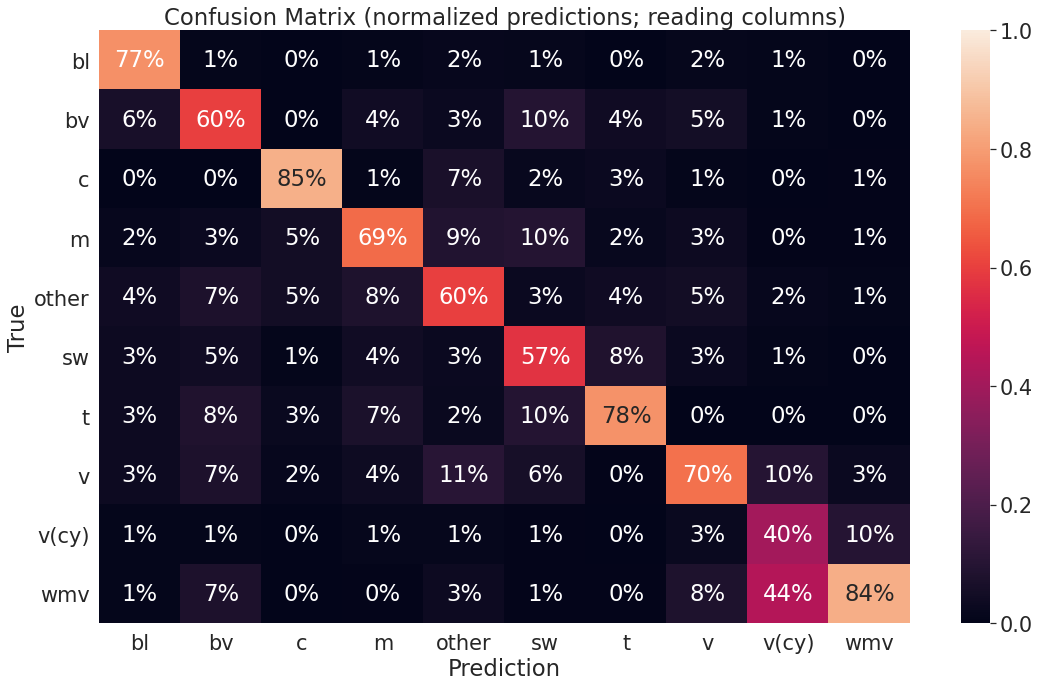

In [60]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(f"{balanced_accuracy_score(y_test, y_pred):.2}")

sns.set(font_scale=1.9)
plt.figure(figsize=(16,10))
cm = confusion_matrix(le.fit_transform(y_test), y_pred, normalize='pred')

sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()), fmt='.0%',
           vmin=0, vmax=1)
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title(f"Confusion Matrix (normalized predictions; reading columns)")
sns.set(font_scale=1.8)
plt.tight_layout()
plt.savefig(f"{created_data_path}/results/confusionmatrix_2019data_{nb_classes}classes_normalizepred.png")

# Dataframe of 2020 data (all plates so far) & model predictions

In [11]:
target_insect = 'wmv'

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels
df_2020 = pd.DataFrame()
df_2020['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/2020*.jpg"))
df_2020['pname'] = df_2020['x'].apply(lambda p: p.split('/')[-1][:-4])
df_2020['pname'] = df_2020['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_2020['y_text'] = df_2020['x'].apply(lambda x: x.split('/')[-2])
df_2020['y_text'] = df_2020['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

df_2020.drop(df_2020[df_2020.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)

df_2020['y'] = le.fit_transform(df_2020.y_text)

pred2 = model.predict(valid_generator(df_2020.x.tolist(), df_2020.y.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         steps= len(df_2020.x.tolist()) / batch_size, 
                         verbose=1)
y_pred2 = np.argmax(pred2, axis=1)

df_2020['pred'] = y_pred2

df_2020['date'] = df_2020.pname.apply(lambda x: x.split('_')[2])
df_2020['date'] = df_2020.date.str.lower()
df_2020['weeknr'] = df_2020['date'].apply(lambda x: x if x.startswith('w') else to_weeknr(date=x))

# # EXCLUDING WEIRD WEEKS
df_2020 = df_2020[~df_2020.weeknr.isin(['w04','w05'])]
df_2020['location'] = df_2020.pname.apply(lambda x: x.split('_')[1])
df_2020.location = df_2020.location.str.lower()
df_2020.location = df_2020['location'].map(location_mapping)

assert df_2020.location.isna().sum() == 0

566/565 [==============================] - 20s 35ms/step


## Location based 2019 data

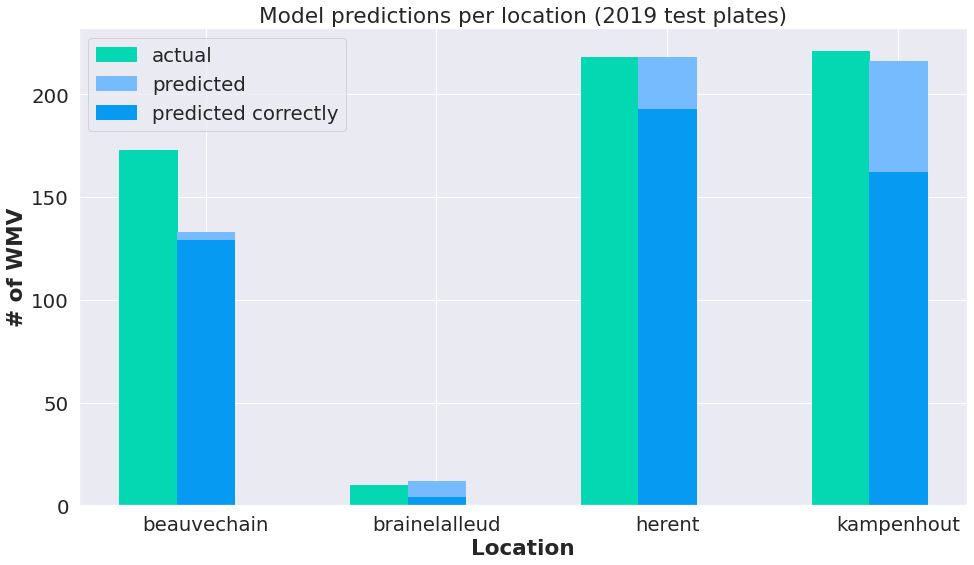

In [105]:
tmpdf = df_2019test#[df_2019test.location=='herent']
column = 'location'
results = [{"week": None,"actual":[], "predicted":[], "predicted_correct": [], 
            "cm": None, "nrofplates": None, "nrofinsects": None} for i in tmpdf[column].unique().tolist()]
for i, (w,sub) in enumerate(tmpdf.groupby(column)):
    results[i]['week'] = w
    results[i]['actual'] = len(sub[sub.y_text==target_insect])
    results[i]['predicted_correct'] = len(sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)])
    results[i]['predicted'] = len(sub[sub.pred==inv_name_map[target_insect]])
    results[i]['cm'] = confusion_matrix(y_true=sub.y.values, y_pred=sub.pred.values, normalize='pred')
#     results[i]['nrofplates'] = len(tmpdf[tmpdf.weeknr==w].pname.unique())
    results[i]['nrofinsects'] = sub.shape[0]
# print(results[0])

###########################
plt.figure(figsize=(14,8))
# set width of bar
barWidth = 0.25
sns.set(font_scale=1.8)
# set height of bar
bars1 = [i['actual'] for i in results]
bars2 = [i['predicted'] for i in results]
bars3 = [i['predicted_correct'] for i in results]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='xkcd:aquamarine', width=barWidth, edgecolor='xkcd:aquamarine', label='actual')
plt.bar(r2, bars2, color='xkcd:sky blue', width=barWidth, edgecolor='xkcd:sky blue', label='predicted')
plt.bar(r2, bars3, color='xkcd:azure', width=barWidth, edgecolor='xkcd:azure', label='predicted correctly')
 
# Add xticks on the middle of the group bars
plt.xlabel('Location', fontweight='bold')
plt.ylabel('# of WMV', fontweight='bold')
# plt.ylim(0,350)
plt.xticks([r + barWidth for r in range(len(bars1))], [i['week'] for i in results])

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.title(f"Model predictions per location (2019 test plates)")
plt.savefig(f"{created_data_path}/results/histogram_predicted#2020data_{nb_classes}classes.png")

In [106]:
location = 'kampenhout'
tmp = df_2019test[df_2019test.location==location]
res = {}
res['species'] = tmp[(tmp.y_text=='wmv') & (tmp.pred!= inv_name_map['wmv'])].pred.value_counts().index.map(name_map).tolist()
res['counts'] = tmp[(tmp.y_text=='wmv') & (tmp.pred!= inv_name_map['wmv'])].pred.value_counts().tolist()
frame = pd.DataFrame(res)
frame

,species,counts
0,v(cy),42
1,v,8
2,other,3
3,bv,3
4,sw,1
5,c,1
6,bl,1


## 2019 test plates - Predicted # of wmvs

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 432x288 with 0 Axes>

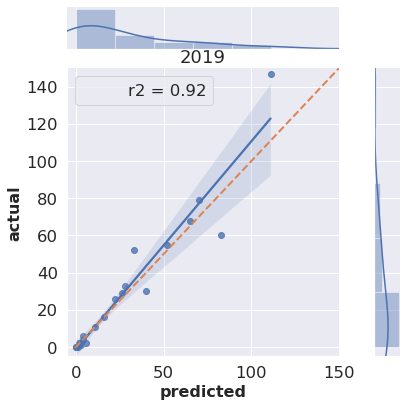

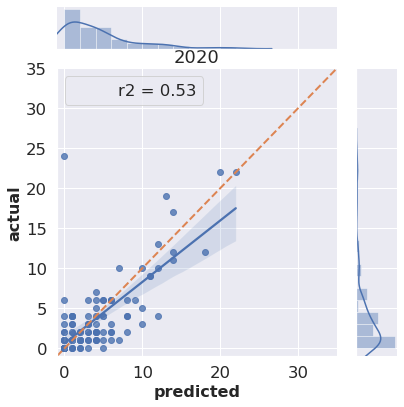

In [146]:

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

df_test = df_2019[df_2019.pname.isin(test_plates)]
df_test['pred'] = y_pred

actual19, predicted19 = [], []
for i, sub in df_test.groupby('pname'):
    actual19.append(len(sub[sub.y == inv_name_map['wmv']]))
    predicted19.append(len(sub[sub.pred==inv_name_map['wmv']]))
plt.figure()
h = sns.jointplot(predicted19,actual19, kind="reg", stat_func=r2); 
plt.ylim(-5,150); plt.xlim(-5,150);
h.set_axis_labels('predicted', 'actual', fontsize=16,fontweight='bold')
h.ax_joint.plot([-.5,150], [-.5,150], '--', linewidth = 2)
plt.tight_layout()
plt.title(f"2019")

plt.savefig(f"{created_data_path}/results/jointplot_predicted19#2019data_{nb_classes}classes.png")


# df_2020 = df_2020[df_2020.y_text==target_insect]

actual20, predicted20, predicted20_correct = [], [], []
for n, (i, sub) in enumerate(df_2020.groupby('pname')):
    real_nr = len(sub[sub.y_text==target_insect])
    pred_nr = len(sub[sub.pred==inv_name_map[target_insect]])
    correct_nr = len(sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)])
    actual20.append(real_nr)
    predicted20.append(pred_nr)

h = sns.jointplot(x=predicted20, y=actual20, kind="reg", stat_func=r2); 
h.set_axis_labels(xlabel='predicted', ylabel='actual', fontsize=16,fontweight='bold')
plt.tight_layout()
# plt.plot([0, 1], [0, 1])
# plt.plot([0, 4], [1.5, 0], linewidth=2)
h.ax_joint.plot([-1,35], [-1,35], '--', linewidth = 2)
plt.ylim(-1,35)
plt.xlim(-1,35)
plt.title(f"2020")

plt.savefig(f"{created_data_path}/results/jointplot_predicted#2020data_{nb_classes}classes.png")

In [92]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt, pandas as pd
n=1000
m1=-3
m2=3

df1 = pd.DataFrame({"predicted": predicted19, "actual": actual19})
df2 = pd.DataFrame({"predicted": predicted20, "actual": actual20})
df1['kind'] = '2019'
df2['kind'] = '2020'
df=pd.concat([df1,df2])

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    sns.set(font_scale=2.)
    plt.figure(figsize=(20,14))

    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    plt.legend(legends, loc='upper left')
    plt.ylim(-5.,150)
    plt.xlim(-5.,150)
    plt.plot([-5,150], [-5,150], ':', linewidth = 2)
    

<Figure size 1440x1008 with 0 Axes>

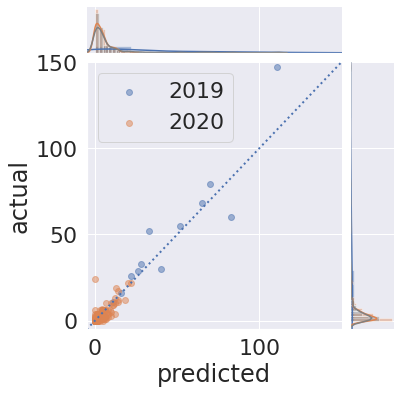

In [93]:
multivariateGrid('predicted', 'actual', 'kind', df=df)
plt.savefig(f"{created_data_path}/results/jointplot_predicted#2019&2020data_{nb_classes}classes.png")

## Insect  counts in 2019 data

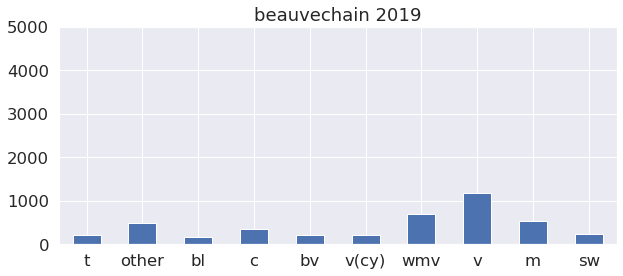

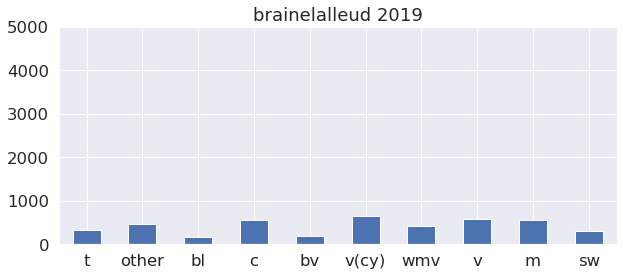

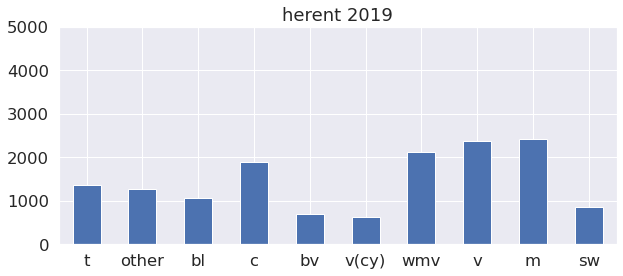

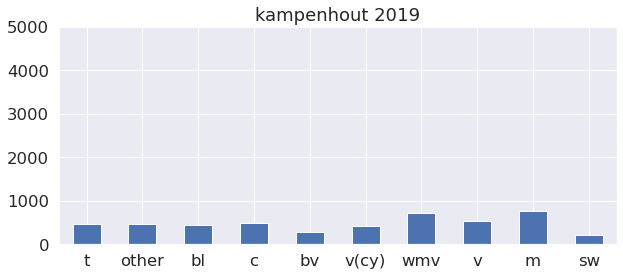

In [142]:
sns.set(font_scale=1.5)
for i, sub in df_2019.groupby(["location"]):
    plt.figure(figsize=(10,4))
    plt.title(f"{i} 2019")
    sub.y_text.value_counts()[sub.y_text.unique()].plot(kind='bar', rot=0)
    plt.ylim(0,5000)
    plt.savefig(f"{created_data_path}/results/hist_insects_2019data_{i}.png")

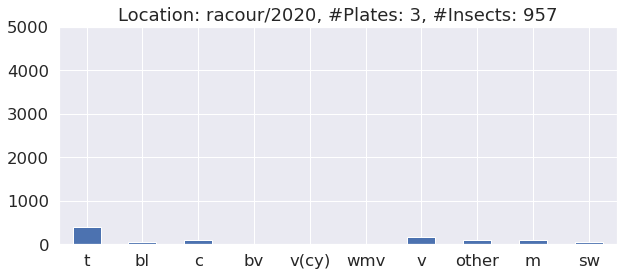

In [140]:
location = 'racour'
plt.figure(figsize=(10,4))
plt.ylim(0,5000)
tmp = df_2020[df_2020.location==location]
tmp.y_text.value_counts()[tmp.y_text.unique()].plot(kind='bar', rot=0)
plt.title(f"Location: {location}/2020, #Plates: {tmp.pname.unique().shape[0]}, #Insects: {tmp.shape[0]}")
plt.savefig(f"{created_data_path}/results/hist_insects_2020data_{location}.png")

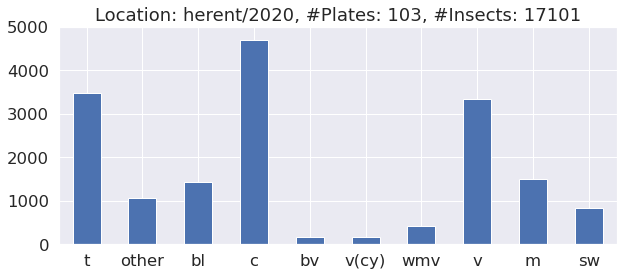

In [141]:
location = 'herent'
plt.figure(figsize=(10,4))
plt.title(f"{location} 2020")
plt.ylim(0,5000)
tmp = df_2020[df_2020.location==location]
tmp.y_text.value_counts()[tmp.y_text.unique()].plot(kind='bar', rot=0)
plt.title(f"Location: {location}/2020, #Plates: {tmp.pname.unique().shape[0]}, #Insects: {tmp.shape[0]}")
plt.savefig(f"{created_data_path}/results/hist_insects_2020data_{location}.png")

In [96]:
df_2020.weeknr.value_counts()

w29    3458
w32    2640
w30    2538
w28    2369
w27    2332
w31    2121
w33    1906
w26     694
Name: weeknr, dtype: int64

In [97]:
df_2020[df_2020.location=='racour'].pname.value_counts()

2020_Racour_20200713_B_F10_51 mm_ISO160_1-15 s_IncandescentWB     458
2020_Racour_20200803_A_F10_51 mm_ISO160_1-15 s_incandescent_14    252
2020_Racour_20200803_B_F10_51 mm_ISO160_1-15 s_incandescent_15    247
Name: pname, dtype: int64

#### Jointplot train data 2019

In [98]:
# X_train = df_2019[~df_2019.pname.isin(test_plates)].x
# y_train = df_2019[~df_2019.pname.isin(test_plates)].y

# predtrain = model.predict(valid_generator(X_train.tolist(), y_train.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
#                          steps= len(X_train) / batch_size, 
#                          verbose=1)
# y_predtrain = np.argmax(predtrain, axis=1)
# # df_train = df_2019[~df_2019.pname.isin(test_plates)]
# # df_train['pred'] = y_predtrain

# # actual, predicted = [], []
# # for i, sub in df_train.groupby('pname'):
# #     actual.append(len(sub[sub.y == inv_name_map['wmv']]))
# #     predicted.append(len(sub[sub.pred==inv_name_map['wmv']]))

# # h = sns.jointplot(predicted,actual, kind="reg", stat_func=r2); plt.ylim(-.9,150); plt.xlim(-.9,150);
# # h.set_axis_labels('predicted', 'actual', fontsize=16,fontweight='bold')
# # h.ax_joint.plot([-.5,150], [-.5,150], '--', linewidth = 2)
# # plt.tight_layout()
# # plt.title(f"Number of classes: {nb_classes}")

# # plt.savefig(f"{created_data_path}/results/jointplot_predicted#2019data_train_{nb_classes}classes.png")

## Whole 2020  -  Joint plot (actual vs predicted)

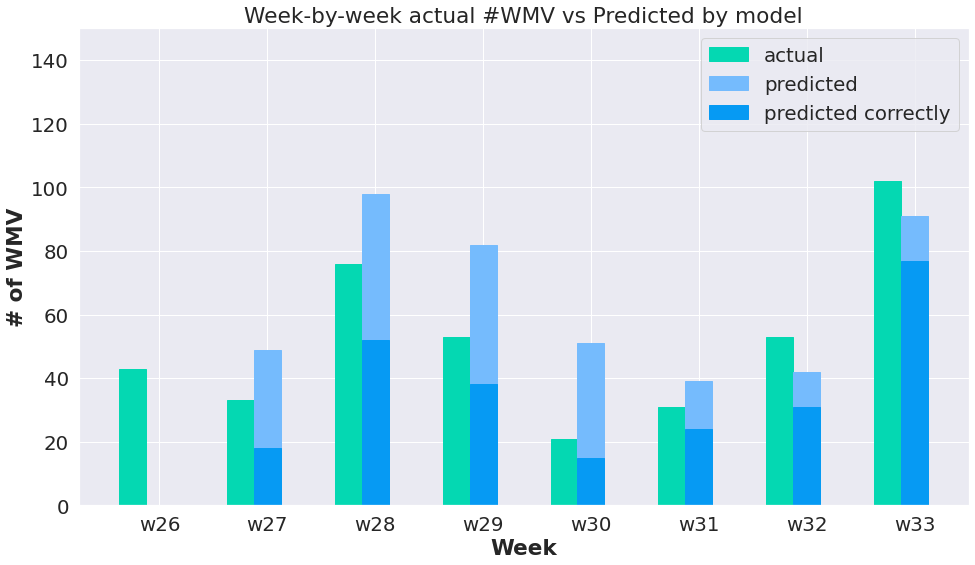

In [149]:
results = [{"week": None,"actual":[], "predicted":[], "predicted_correct": [], 
            "cm": None, "nrofplates": None, "nrofinsects": None} for i in df_2020.weeknr.unique().tolist()]
for i, (w,sub) in enumerate(df_2020.groupby('weeknr')):
    results[i]['week'] = w
    results[i]['actual'] = len(sub[sub.y_text==target_insect])
    results[i]['predicted_correct'] = len(sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)])
    results[i]['predicted'] = len(sub[sub.pred==inv_name_map[target_insect]])
    results[i]['cm'] = confusion_matrix(y_true=sub.y.values, y_pred=sub.pred.values, normalize='pred')
    results[i]['nrofplates'] = len(df_2020[df_2020.weeknr==w].pname.unique())
    results[i]['nrofinsects'] = sub.shape[0]
# print(results[0])

###########################
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
# set width of bar
barWidth = 0.25
sns.set(font_scale=1.8)
# set height of bar
bars1 = [i['actual'] for i in results]
bars2 = [i['predicted'] for i in results]
bars3 = [i['predicted_correct'] for i in results]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='xkcd:aquamarine', width=barWidth, edgecolor='xkcd:aquamarine', label='actual')
plt.bar(r2, bars2, color='xkcd:sky blue', width=barWidth, edgecolor='xkcd:sky blue', label='predicted')
plt.bar(r2, bars3, color='xkcd:azure', width=barWidth, edgecolor='xkcd:azure', label='predicted correctly')
 
# Add xticks on the middle of the group bars
plt.xlabel('Week', fontweight='bold')
plt.ylabel('# of WMV', fontweight='bold')
plt.ylim(0,150)
plt.xticks([r + barWidth for r in range(len(bars1))], [i['week'] for i in results])

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.title(f"Week-by-week actual #WMV vs Predicted by model")
plt.savefig(f"{created_data_path}/results/histogram_predicted#2020data_weekbyweek.png")

In [100]:
df_2020.weeknr.value_counts()

w29    3458
w32    2640
w30    2538
w28    2369
w27    2332
w31    2121
w33    1906
w26     694
Name: weeknr, dtype: int64

In [24]:
created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data/'

# CREATING NECESSARY DIRECTORIES FOR THE PROJECT
path_annotations = f'{created_data_path}/annotations_photobox/'
path_images = f'{created_data_path}/images_photobox/'
path_voc_annotations = f'{created_data_path}/voc_annotations_photobox/'
path_crops_export = f'{created_data_path}/crops_export_photobox/'


In [25]:
# target_insect = 'wmv'

# # Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels
# df_photobox = pd.DataFrame()
# df_photobox['x'] = pd.Series(glob.glob(f"{path_crops_export}/*.jpg"))
# df_photobox['pname'] = df_photobox['x'].apply(lambda p: p.split('/')[-1][:-4])
# df_photobox['pname'] = df_photobox['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# df_photobox['y_text'] = df_photobox['x'].apply(lambda x: x.split('/')[-2])
# df_photobox['y_text'] = df_photobox['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

# # df_photobox.drop(df_photobox[df_photobox.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)

# df_photobox['y'] = le.fit_transform(df_photobox.y_text)

In [26]:
# pred2 = model.predict(valid_generator(df_photobox.x.tolist(), df_photobox.y.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
#                          steps= len(df_photobox.x.tolist()) / batch_size, 
#                          verbose=1)
# y_pred2 = np.argmax(pred2, axis=1)
# df_photobox['pred'] = y_pred2